In [2]:
# Goal: Play around with the 7774 luminosity a bít and see if we can get any constraints from that
import numpy as np
import numba
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

In [2]:
# Refs: Jerkstrand+2015
# eqn3: L^ul_rec = 4\pi/3 (V_core*t)^3 f_O \psi n_e^2 \alpha_eff h \nu_ul
# \psi \approx 1-0.5 in relevant time range
# \alpha(T=2500) = 2.8e-13
# \alpha(T=5000) = 1.6e-13
# \alpha(T=7500) = 1.1e-13
# [\alpha] = cm^3 /s

In [5]:
lum = 27e38 # erg/s
line_width = 31.1 # A

def extract_model_line_velocity(line_width):
    width = line_width
    velocity_sigma = width/6300 * 299792.458
    return 2*np.sqrt(np.log(2)) * velocity_sigma
print('Velocity: ', extract_model_line_velocity(line_width), 'km/s')
velocity_cm = extract_model_line_velocity(line_width)*1e3 * 1e2 # km -> cm
print('Velocity: ', velocity_cm, 'cm/s')

Velocity:  2464.241508436201 km/s
Velocity:  246424150.84362012 cm/s


In [9]:
h = const.h.cgs.value
c = const.c.cgs.value
wave7774 = 7774*u.Angstrom.to(u.cm)

In [12]:
t = 157.7 * u.d.to(u.s)
psi=0.5
for alpha in [2.8e-13, 1.6e-13, 1.1e-13]:
    fone2 = lum*3/4/np.pi * (velocity_cm*t)**-3 / psi / alpha / (h*c/wave7774)
    print(alpha, fone2, '%e' % np.sqrt(fone2))

2.8e-13 4.760239564385411e+16 2.181797e+08
1.6e-13 8.33041923767447e+16 2.886247e+08
1.1e-13 1.2116973436617411e+17 3.480944e+08


In [13]:
# Conclusion: Values seem roughly in line with J15 paper with 11dh (similar ball park anyway)


In [14]:
# Ratio between alpha*nu for 7774 and 9263
print('T=2500', (2.8e-13/7774)/(1.1e-13/9263))
print('T=5000', (1.6e-13/7774)/(6.4e-14/9263))
print('T=7500', (1.1e-13/7774)/(4.5e-14/9263))
# ok.. too small to measure -> irrelevant to determine Temperature

T=2500 3.033000444371682
T=5000 2.9788397221507585
T=7500 2.9126432838807426


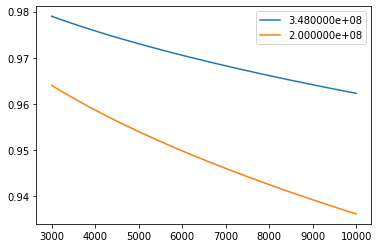

In [3]:
# estimate range of d_2
@numba.njit(inline='always')
def nu1_calc_lte(temp):
    g_u1 = 5
    g_g = 9
    E_1 = 22830 # K
    return g_u1/g_g * np.exp(-E_1/temp)

# simple estimate just solving eqn48 in J+Handbook to N_u
@numba.njit(inline='always')
def nu2_estimate0(temp, ne):
    Q_2g = 8.631e-6/temp**0.5 * 1 / 1 * ne
    Q_21 = 8.631e-6/temp**0.5 * 0.07 / 1 * ne
    E_u2 = 48620 # K
    E_u1 = 22830 # K
    A_21 = 1.26
    N_1 = nu1_calc_lte(temp)
    el1 = Q_2g*np.exp(-E_u2/temp)*1/9 + N_1*Q_21*np.exp(-(E_u2-E_u1)/temp)*1/5
    el2 = A_21 + Q_21 + Q_2g
    return el1/el2

@numba.njit(inline='always')
def nu2_calc_lte(temp):
    g_u2 = 1
    g_g = 9
    E_2 = 48620 # K
    return g_u2/g_g * np.exp(-E_2/temp)

temp = np.linspace(3000, 9999)
for ne in [3.48e8, 2.0e8]:
    d2 = nu2_estimate0(temp, ne)/nu2_calc_lte(temp)
    plt.plot(temp, d2, label='%e' % ne)
plt.legend()